In [ ]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import math
import random
import matplotlib.pyplot as plt

from bravado.client import SwaggerClient
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})

fetch_binary_matrix: 
- Calls the cBioPortal mutations endpoint for the given molecular profile and sample list.
- Iterates mutations and keeps only variantType == 'SNP'.
- Constructs a mutation label as "GENE_proteinPosStart" and collects rows {patientId, gene}.
- Builds a binary pivot table: rows = patientId (optionally prefixed with study_id), columns = mutation labels, values are 0/1 (presence).
- Returns an int DataFrame; returns an empty DataFrame if no data.

build_background_matrix: 
- Calls fetch_binary_matrix for each background study spec.
- Aligns all returned matrices to the union of genes (columns) using reindex with fill_value=0.
- Concatenates patients from all background studies, then deduplicates by patient index keeping max (so if a patient appears in multiple sources, presence is OR'ed).
- Returns the combined background DataFrame (patients × mutation labels).

split_members: 
- Randomly shuffles patient IDs with a numpy Generator seeded by rng_seed.
- Splits patient IDs into train (first frac_train fraction) and held-out (rest).
- Returns two DataFrames: train_in (used to estimate p_in) and held_out_members (used as positive eval set).

align_gene_space: 
- Computes the union of columns across the three DataFrames.
- Reindexes each DataFrame to that common column set, filling missing columns with 0 and converting to int.
- Returns the aligned DataFrames and the pd.Index of all_genes.


In [17]:
# fetch all mutations from cBioPortal and build binary matrix of patients x mutations
def fetch_binary_matrix(
    cbioportal,
    study_id: str,
    sample_list_id: str,
    molecular_profile_id: str,
    prefix_patient_ids: bool = True,
) -> pd.DataFrame:
    mutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
        molecularProfileId=molecular_profile_id,
        sampleListId=sample_list_id,
        projection='DETAILED'
    ).result() # return a  list of dictionaries

    mutation_rows = []
    for m in mutations: # loop through every mutation record and extract relevant info
        gene = m["gene"]["hugoGeneSymbol"]
        patient = m["patientId"]
        proteinChange = m["proteinChange"]
        proteinPosStart = m['proteinPosStart']
        variantType = m['variantType']
        if prefix_patient_ids:
            patient = f"{study_id}__{patient}"

        if variantType == 'SNP':
            mutation = f"{gene}_{proteinPosStart}"
            mutation_rows.append({"patientId": patient, "gene": mutation})

    df = pd.DataFrame(mutation_rows)
    # print(f"Dataframe for SNP variant type: \n {df.head()}")
    if df.empty:
        return pd.DataFrame()
    

    binary_matrix = (
        df.assign(value=1)
          .drop_duplicates(["patientId", "gene"]) 
          .pivot_table(
              index="patientId",
              columns="gene",
              values="value",
              aggfunc="max",
              fill_value=0
           )
          .astype(int)
    )

    binary_matrix.columns.name = None
    binary_matrix.index.name = None

    # print(f"Binary Matrix of patientId and type of gene mutation: \n {binary_matrix.iloc[:5, :10]}")
    return binary_matrix


def build_background_matrix( #combine multiple studies into one background matrix (represent non-members or control data)
    cbioportal,
    study_specs: List[Dict[str, str]]
) -> pd.DataFrame:

    matrices = []
    for spec in study_specs:
        mat = fetch_binary_matrix(
            cbioportal,
            study_id=spec["study_id"],
            sample_list_id=spec["sample_list_id"],
            molecular_profile_id=spec["molecular_profile_id"],
            prefix_patient_ids=True
        )
        if mat is not None and mat.shape[0] > 0:
            matrices.append(mat)

    if not matrices:
        return pd.DataFrame()

    # union-align across matrices for all the mutations seen in background studies
    all_genes = sorted(set.union(*(set(m.columns) for m in matrices))) # union-align columns
    mats_aligned = [m.reindex(columns=all_genes, fill_value=0).astype(int) for m in matrices]

    background = pd.concat(mats_aligned, axis=0)
    background = background.groupby(background.index).max()

    # print(f"Background matrix of all studies: \n {background.iloc[:5, :10]}")
    return background


def split_members( #split members into training and held-out sets randomly
    matrix_D: pd.DataFrame,
    frac_train: float = 0.8,
    rng_seed: int = 0
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    rng = np.random.default_rng(rng_seed)
    patient_ids = matrix_D.index.to_numpy()
    rng.shuffle(patient_ids)

    split_idx = int(len(patient_ids) * frac_train)
    train_ids = patient_ids[:split_idx]
    heldout_ids = patient_ids[split_idx:]

    train_in = matrix_D.loc[train_ids].copy()
    held_out_members = matrix_D.loc[heldout_ids].copy()

    return train_in, held_out_members

def align_gene_space( # unifies different studies into one set of all unique genes
    train_in: pd.DataFrame,
    held_out_members: pd.DataFrame,
    background_out: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Index]:
    """
    all_genes:  takes every unique column name that appears in any of the three DataFrames
    _align(df): Ensures all dataframes have the same number of genes
    """
    all_genes = sorted(
        set(train_in.columns)
        | set(held_out_members.columns)
        | set(background_out.columns)
    )

    def _align(df):
        return df.reindex(columns=all_genes, fill_value=0).astype(int)

    return _align(train_in), _align(held_out_members), _align(background_out), pd.Index(all_genes)


estimate_freqs:
- Counts mutated patients per column.
- Computes p(g) = (count + alpha) / (num_patients + 2*alpha). (Laplace-like smoothing.)
- Returns a pd.Series of per-gene mutation probabilities.

llr_score: 
- For an observed set of genes, sums log( p_in[g] / p_out[g] ) over genes present in both p_in and p_out and with positive probabilities.
- Returns -1.0 * sum(log ratio). (Note: the function negates the raw log-sum; be aware of this sign choice when interpreting LLR and later Bayes calculation.)

sample_variant_subset: 
- Given a binary row for a patient, lists mutated variants.
- If m >= number mutated, returns all; otherwise samples m distinct variants without replacement using a numpy Generator.
- Returns the sampled variant labels.

get_score_distributions: 
- For each patient in members_df and nonmembers_df:
    Repeat draws_per_individual times: sample m variants (sample_variant_subset), compute llr_score, collect scores.
- Returns two lists: member_scores and nonmember_scores.

In [ ]:
def estimate_freqs( # mutation frequency estimation with Laplace smoothing
    matrix: pd.DataFrame,
    alpha: float = 1.0
) -> pd.Series:
    """
    p(gene) = (count_mutated + alpha) / (num_patients + 2*alpha). Laplace-smoothing for rounding issues
    """
    num_patients = matrix.shape[0]
    gene_counts = matrix.sum(axis=0)
    p = (gene_counts + alpha) / (num_patients + 2 * alpha)
    return p.astype(float)


def llr_score( # log likelihood ratio score computation
    observed_genes: List[str],
    p_in: pd.Series,
    p_out: pd.Series
) -> float:
    """
    Compute sum_{g in observed_genes} log( p_in[g] / p_out[g] ).
    """
    score = 0.0
    for g in observed_genes:
        if g not in p_in.index or g not in p_out.index:
            continue
        pin = p_in[g]
        pout = p_out[g]
        if pin <= 0 or pout <= 0:
            continue
        score += math.log(pin / pout)
    return -1.0 * score # so higher scores can represent “less likely in members”

def sample_variant_subset( # sampling subsets of gene mutations
    row: pd.Series,
    m: int,
    rng: np.random.Generator
) -> List[str]:
    """
    function simulates random subsets of gene mutations per patient
    """
    mutated_genes = list(row.index[row.values == 1])
    if len(mutated_genes) == 0:
        return []
    if m >= len(mutated_genes):
        return mutated_genes
    # sample without replacement
    subset = rng.choice(mutated_genes, size=m, replace=False)
    return list(subset)


def get_score_distributions( # generate score distributions for members and non-members
    members_df: pd.DataFrame,
    nonmembers_df: pd.DataFrame,
    p_in: pd.Series,
    p_out: pd.Series,
    m: int,
    draws_per_individual: int = 5,
    rng_seed: int = 0
) -> Tuple[List[float], List[float]]:
    rng = np.random.default_rng(rng_seed)

    member_scores = []
    for pid, row in members_df.iterrows():
        for _ in range(draws_per_individual):
            genes_subset = sample_variant_subset(row, m, rng)
            if len(genes_subset) == 0:
                continue
            score = llr_score(genes_subset, p_in, p_out)
            member_scores.append(score)

    nonmember_scores = []
    for pid, row in nonmembers_df.iterrows():
        for _ in range(draws_per_individual):
            genes_subset = sample_variant_subset(row, m, rng)
            if len(genes_subset) == 0:
                continue
            score = llr_score(genes_subset, p_in, p_out)
            nonmember_scores.append(score)

    return member_scores, nonmember_scores


k-anon functions 

In [ ]:
# K-ANONYMITY FUNCTIONS
def compute_equivalence_class_sizes(df: pd.DataFrame) -> pd.Series:
    """Return a Series mapping patient index -> equivalence class size (rows identical)."""
    if df.empty:
        return pd.Series(dtype=int)
    # build signatures as tuples (fast enough for moderate sizes)
    sig = df.apply(lambda r: tuple(r.values), axis=1)
    sizes = sig.map(sig.value_counts())
    sizes.index = df.index
    return sizes

def k_anonymize_by_suppress(df: pd.DataFrame, k: int, max_iter: int | None = None):
    """
    Simple suppression-based k-anonymity for binary matrix.
    - Iteratively suppress (set to 0) the least-prevalent variant column
      until every equivalence class (identical rows) has size >= k or
      until max_iter reached / no columns left.
    - Returns anonymized_df, list_of_suppressed_columns, final_equivalence_sizes
    Note: suppression is destructive (alters utility). Keep copies if needed.
    """
    df = df.copy()
    if df.empty or k <= 1:
        return df, [], compute_equivalence_class_sizes(df)

    max_iter = max_iter or df.shape[1] * 2
    suppressed = []

    for _ in range(max_iter):
        eq_sizes = compute_equivalence_class_sizes(df)
        if eq_sizes.empty or (eq_sizes >= k).all():
            break

        # pick least-prevalent column (lowest sum). Tie-breaker: first.
        col_support = df.sum(axis=0)
        if col_support.size == 0:
            break
        col_to_suppress = col_support.idxmin()

        # if column already all zeros, drop it
        if col_support[col_to_suppress] == 0:
            # drop to speed future checks
            df = df.drop(columns=[col_to_suppress])
            suppressed.append(col_to_suppress)
            if df.shape[1] == 0:
                break
            continue

        # suppress by zeroing the column (global suppression)
        df[col_to_suppress] = 0
        suppressed.append(col_to_suppress)

        # stop early if no columns left
        if df.shape[1] == 0:
            break

    final_eq = compute_equivalence_class_sizes(df)
    return df.astype(int), suppressed, final_eq

def anonymity_stats(df: pd.DataFrame):
    """Return small dict of anonymity metrics for a binary matrix."""
    sizes = compute_equivalence_class_sizes(df)
    if sizes.empty:
        return {"num_records": 0, "num_unique": 0, "min_eq_size": 0, "median_eq_size": 0}
    return {
        "num_records": len(sizes),
        "num_unique": int((sizes == 1).sum()),
        "min_eq_size": int(sizes.min()),
        "median_eq_size": float(sizes.median()),
        "eq_size_counts": sizes.value_counts().to_dict(),
    }

roc_curve_from_scores: 
- Concatenates scores and builds binary labels (1 for member, 0 for nonmember).
- Iterates unique score thresholds (descending) to compute TPR and FPR at each threshold by comparing score >= threshold.
- Returns thresholds, arrays of FPR and TPR, and AUC computed by trapezoidal integration over (FPR, TPR).

best_operating_point:
- Finds thresholds with FPR <= max_fpr and returns the one among those with maximum TPR (and its fpr/tpr).
- If none meet the FPR constraint, returns {}.

NOTE: commented out the k-anon results becoz its super slow 

In [ ]:
def roc_curve_from_scores(
    member_scores: List[float],
    nonmember_scores: List[float]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:

    scores = np.array(member_scores + nonmember_scores, dtype=float)
    labels = np.array([1]*len(member_scores) + [0]*len(nonmember_scores), dtype=int)
    thresholds = np.sort(np.unique(scores))[::-1]

    tpr_list = []
    fpr_list = []

    for thr in thresholds:
        preds = (scores >= thr).astype(int)

        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))
        tn = np.sum((preds == 0) & (labels == 0))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_arr = np.array(tpr_list)
    fpr_arr = np.array(fpr_list)

    order = np.argsort(fpr_arr)
    fpr_sorted = fpr_arr[order]
    tpr_sorted = tpr_arr[order]
    auc = np.trapezoid(tpr_sorted, fpr_sorted)

    return thresholds, fpr_arr, tpr_arr, auc


def best_operating_point(
    thresholds: np.ndarray,
    fpr_arr: np.ndarray,
    tpr_arr: np.ndarray,
    max_fpr: float = 0.01
) -> Dict[str, float]:
    """
    Among all thresholds that keep FPR <= max_fpr,
    return the one with the highest TPR.

    If none satisfy, return {}.
    """
    ok = np.where(fpr_arr <= max_fpr)[0]
    if len(ok) == 0:
        return {}
    idx = ok[np.argmax(tpr_arr[ok])]
    return {
        "threshold": float(thresholds[idx]),
        "fpr": float(fpr_arr[idx]),
        "tpr": float(tpr_arr[idx]),
    }

def run_open_world_eval(
    cbioportal,
    target_study: Dict[str, str],
    background_studies: List[Dict[str, str]],
    m_list: List[int] = [1,2,3,5,10,20,30],
    frac_train: float = 0.8,
    draws_per_individual: int = 5,
    rng_seed: int = 0,
    k_anonymity_k: int | None = None,
):
    """
    Full pipeline:
    1. Fetch dataset D (target_study).
    2. Fetch background (concat all background_studies).
    3. Split D into train_in vs held_out_members.
    4. Align gene columns.
    5. Estimate p_in, p_out.
    6. For each m, simulate attack, compute ROC, AUC, best operating point.
    """

    # 1. pull D
    D_matrix = fetch_binary_matrix(
        cbioportal,
        study_id=target_study["study_id"],
        sample_list_id=target_study["sample_list_id"],
        molecular_profile_id=target_study["molecular_profile_id"],
        prefix_patient_ids=True
    )

    # 2. pull background
    B_matrix = build_background_matrix(cbioportal, background_studies)

    # 3. split D into train (to estimate p_in) and held-out positives (eval)
    train_in, held_out_members = split_members(D_matrix, frac_train=frac_train, rng_seed=rng_seed)
    outsiders = B_matrix.copy()
    
    # 4. align gene space
    train_in, held_out_members, outsiders, genes = align_gene_space(train_in, held_out_members, outsiders)
    train_out, held_out_outsiders = split_members(outsiders, frac_train=frac_train, rng_seed=rng_seed)
    
    # 5. estimate p_in and p_out
    p_in = estimate_freqs(train_in, alpha=1.0)
    p_out = estimate_freqs(train_out, alpha=1.0)

    results = {}
    k_anon_results = {}

    for m in m_list:
        # 6a. sample subsets and build score distributions
        member_scores, nonmember_scores = get_score_distributions(
            held_out_members,
            held_out_outsiders,
            p_in,
            p_out,
            m=m,
            draws_per_individual=draws_per_individual,
            rng_seed=rng_seed
        )

        # If either is empty (edge case: no mutations), skip
        if len(member_scores) == 0 or len(nonmember_scores) == 0:
            results[m] = {
                "auc": None,
                "best_op_at_1pctFPR": None,
                "member_scores": member_scores,
                "nonmember_scores": nonmember_scores,
            }
            continue
        
        if k_anonymity_k is not None and k_anonymity_k > 1:
            D_matrix, suppressed_D, eq_D = k_anonymize_by_suppress(D_matrix, k=k_anonymity_k)
            B_matrix, suppressed_B, eq_B = k_anonymize_by_suppress(B_matrix, k=k_anonymity_k)
            k_anon_results[m] = {
                "k_anonymity_k": k_anonymity_k,
                "suppressed_columns_target": suppressed_D,
                "suppressed_columns_background": suppressed_B,
                "anonymity_eq_target": eq_D,
                "anonymity_eq_background": eq_B,
                "anonymity_stats_target": anonymity_stats(D_matrix) if isinstance(D_matrix, pd.DataFrame) else {},
                "anonymity_stats_background": anonymity_stats(B_matrix) if isinstance(B_matrix, pd.DataFrame) else {},
            }
            continue

        # 6b. ROC
        thresholds, fpr_arr, tpr_arr, auc = roc_curve_from_scores(member_scores, nonmember_scores)
        
        # 6c. pick operating point with FPR <= 1%
        op = best_operating_point(thresholds, fpr_arr, tpr_arr, max_fpr=0.01)

        results[m] = {
            "auc": auc,
            "best_op_at_1pctFPR": op,
            "member_scores": member_scores,
            "nonmember_scores": nonmember_scores,
            "roc_thresholds": thresholds,
            "roc_fpr": fpr_arr,
            "roc_tpr": tpr_arr,
        }

    return {
        "train_in_shape": train_in.shape,
        "held_out_members_shape": held_out_members.shape,
        "outsiders_shape": outsiders.shape,
        "p_in": p_in,
        "p_out": p_out,
        "results": results,
        "k_anonymity_results": k_anon_results
    }

mutation and copy number histogram 
-- having some errors with generating the structural variant, cant seem to find the correct end point for it 

In [ ]:
def binary_matrix(
    cbioportal,
    study_id: str,
    sample_list_id: str,
    molecular_profile_id: str,
    prefix_patient_ids: bool = True,
):
    """Fetch binary matrix for a molecular profile (mutations, CNVs, SVs)."""

    # Fetch data for the molecular profile
    response = cbioportal(
        molecularProfileId=molecular_profile_id,
        sampleListId=sample_list_id,
        projection='DETAILED',
    ).result()
    if not response:
        return pd.DataFrame()

    rows = []
    for r in response:
        gene = r["gene"]["hugoGeneSymbol"]
        patient = r["patientId"]
        protein_pos = getattr(r, "proteinPosStart", None)
        mutation_label = f"{gene}_{protein_pos}" if protein_pos else gene
        if prefix_patient_ids:
            patient = f"{study_id}__{patient}"
        rows.append({
            "patientId": patient,
            "gene": mutation_label
        })

    df = pd.DataFrame(rows)
    if df.empty:
        return pd.DataFrame()

    # Create binary matrix
    mat = (
        df.assign(value=1)
          .drop_duplicates(["patientId", "gene"])
          .pivot_table(
              index="patientId",
              columns="gene",
              values="value",
              aggfunc="max",
              fill_value=0
          )
          .astype(int)
    )

    # Count number of alterations per patient
    mat["total_alterations"] = mat.sum(axis=1)
    return mat

# --- Molecular Profiles for MSK-CHORD 2024 ---
msk_chord_study = {
    "study_id": "msk_chord_2024",
    "sample_list_id": "msk_chord_2024_all",
    "molecular_profile_id_mut": "msk_chord_2024_mutations",
    "molecular_profile_id_cna": "msk_chord_2024_cna",
    "molecular_profile_id_sv": "msk_chord_2024_structural_variants"
}

# --- Fetch data ---
mut_df = binary_matrix(
    cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_mut"],
)
cna_df = binary_matrix(
    cbioportal.Discrete_Copy_Number_Alterations.getDiscreteCopyNumbersInMolecularProfileUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_cna"]
)
# sv_df = binary_matrix(
#     cbioportal.Structural_Variants.getStructuralVariantsInMolecularProfileBySampleListIdUsingGET,
#     msk_chord_study["study_id"],
#     msk_chord_study["sample_list_id"],
#     msk_chord_study["molecular_profile_id_sv"]
# )

# --- Plot Histograms ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(mut_df["total_alterations"], bins=50, color="lightcoral", edgecolor="black")
plt.title("Mutations per Patient")
plt.xlabel("Number of Mutations")
plt.ylabel("Patients")
plt.grid(axis='y', alpha=0.6)

plt.subplot(1, 3, 2)
plt.hist(cna_df["total_alterations"], bins=50, color="skyblue", edgecolor="black")
plt.title("Copy Number Alterations per Patient")
plt.xlabel("Number of CNAs")
plt.grid(axis='y', alpha=0.6)

# plt.subplot(1, 3, 3)
# plt.hist(sv_df["total_alterations"], bins=50, color="lightgreen", edgecolor="black")
# plt.title("Structural Variants per Patient")
# plt.xlabel("Number of SVs")
# plt.grid(axis='y', alpha=0.6)

plt.suptitle("MSK-CHORD 2024: Alteration Burden by Variant Type", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Other cancer types
- aml_target_gdc - Acute Myeloid Leukemia (TARGET GDC, 2025)
- blca_msk_2025 - Bladder Cancer (MSK, Eur Urol Open Sci 2025)
- asclc_msk_2024 - Atypical Small Cell Lung Cancer (MSK, Cancer Discov 2024)

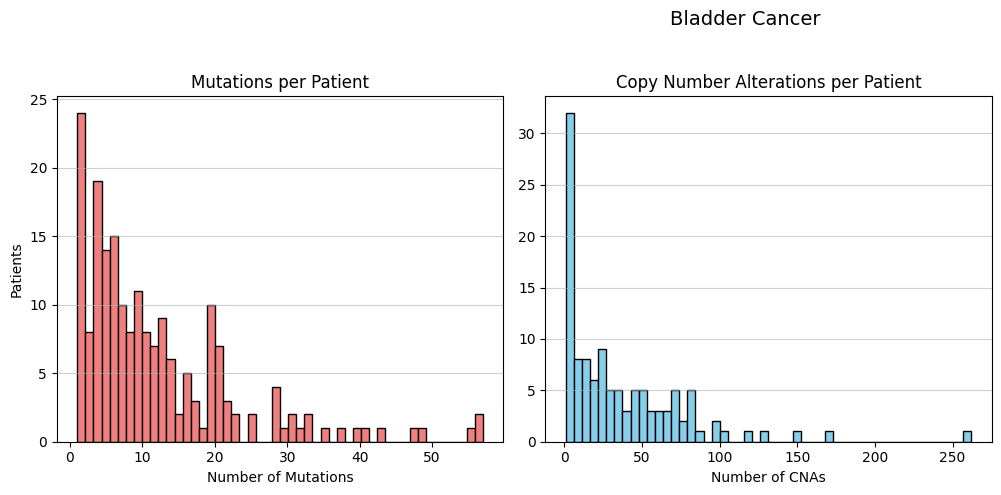

In [35]:
# --- Molecular Profiles for blca_msk_2025 / Bladder cancer---
msk_chord_study = {
    "study_id": "blca_msk_2025",
    "sample_list_id": "blca_msk_2025_all",
    "molecular_profile_id_mut": "blca_msk_2025_mutations",
    "molecular_profile_id_cna": "blca_msk_2025_cna",
    "molecular_profile_id_sv": "blca_msk_2025_structural_variants"
}

# --- Fetch data ---
mut_df = binary_matrix(
    cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_mut"],
)
cna_df = binary_matrix(
    cbioportal.Discrete_Copy_Number_Alterations.getDiscreteCopyNumbersInMolecularProfileUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_cna"]
)


# --- Plot Histograms ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(mut_df["total_alterations"], bins=50, color="lightcoral", edgecolor="black")
plt.title("Mutations per Patient")
plt.xlabel("Number of Mutations")
plt.ylabel("Patients")
plt.grid(axis='y', alpha=0.6)

plt.subplot(1, 3, 2)
plt.hist(cna_df["total_alterations"], bins=50, color="skyblue", edgecolor="black")
plt.title("Copy Number Alterations per Patient")
plt.xlabel("Number of CNAs")
plt.grid(axis='y', alpha=0.6)



plt.suptitle("Bladder Cancer", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

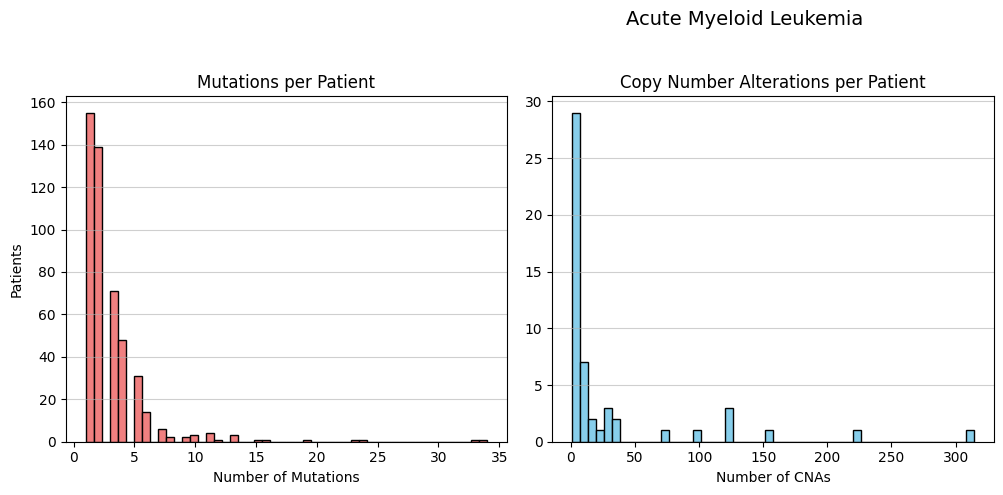

In [29]:
# --- Molecular Profiles for Acute Myeloid Leukemia ---
msk_chord_study = {
    "study_id": "aml_target_gdc",
    "sample_list_id": "aml_target_gdc_all",
    "molecular_profile_id_mut": "aml_target_gdc_mutations",
    "molecular_profile_id_cna": "aml_target_gdc_cna",
    "molecular_profile_id_sv": "aml_target_gdc_structural_variants"
}

# --- Fetch data ---
mut_df = binary_matrix(
    cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_mut"],
)
cna_df = binary_matrix(
    cbioportal.Discrete_Copy_Number_Alterations.getDiscreteCopyNumbersInMolecularProfileUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_cna"]
)


# --- Plot Histograms ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(mut_df["total_alterations"], bins=50, color="lightcoral", edgecolor="black")
plt.title("Mutations per Patient")
plt.xlabel("Number of Mutations")
plt.ylabel("Patients")
plt.grid(axis='y', alpha=0.6)

plt.subplot(1, 3, 2)
plt.hist(cna_df["total_alterations"], bins=50, color="skyblue", edgecolor="black")
plt.title("Copy Number Alterations per Patient")
plt.xlabel("Number of CNAs")
plt.grid(axis='y', alpha=0.6)


plt.suptitle("Acute Myeloid Leukemia", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

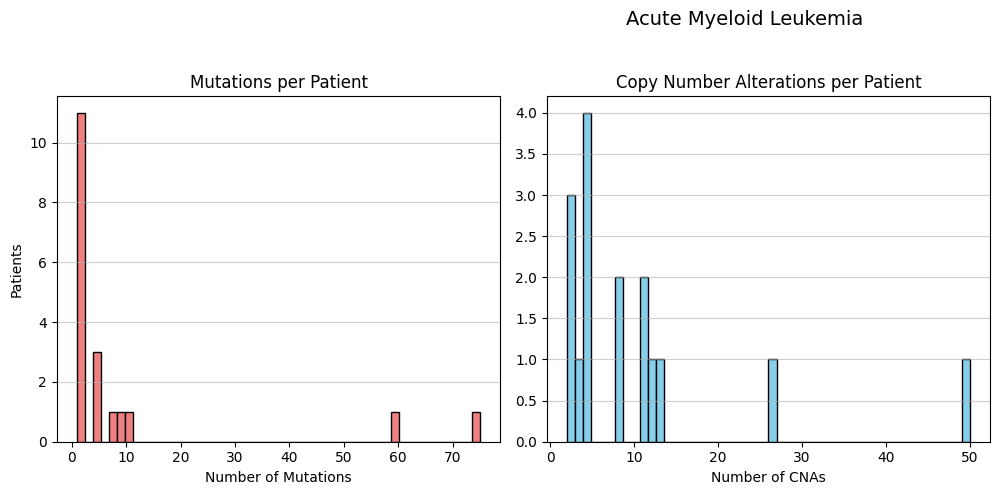

In [31]:
# --- Molecular Profiles for asclc_msk_2024 - Acute Myeloid Leukemia ---
msk_chord_study = {
    "study_id": "asclc_msk_2024",
    "sample_list_id": "asclc_msk_2024_all",
    "molecular_profile_id_mut": "asclc_msk_2024_mutations",
    "molecular_profile_id_cna": "asclc_msk_2024_cna",
    "molecular_profile_id_sv": "asclc_msk_2024_structural_variants"
}

# --- Fetch data ---
mut_df = binary_matrix(
    cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_mut"],
)
cna_df = binary_matrix(
    cbioportal.Discrete_Copy_Number_Alterations.getDiscreteCopyNumbersInMolecularProfileUsingGET,
    msk_chord_study["study_id"],
    msk_chord_study["sample_list_id"],
    msk_chord_study["molecular_profile_id_cna"]
)


# --- Plot Histograms ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(mut_df["total_alterations"], bins=50, color="lightcoral", edgecolor="black")
plt.title("Mutations per Patient")
plt.xlabel("Number of Mutations")
plt.ylabel("Patients")
plt.grid(axis='y', alpha=0.6)

plt.subplot(1, 3, 2)
plt.hist(cna_df["total_alterations"], bins=50, color="skyblue", edgecolor="black")
plt.title("Copy Number Alterations per Patient")
plt.xlabel("Number of CNAs")
plt.grid(axis='y', alpha=0.6)


plt.suptitle("Acute Myeloid Leukemia", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Zoomed in for first bin in Mutation and CNAs

In [ ]:
def first_bin_analysis(df, variant_type):
    print(f"\n--- {variant_type} Analysis for First Bin ---")
    bins = 50
    counts, bin_edges = np.histogram(df["total_alterations"], bins=bins)
    first_bin_min, first_bin_max = float(bin_edges[0]), float(bin_edges[1])

    patients_first_bin = df[
        (df["total_alterations"] >= first_bin_min) &
        (df["total_alterations"] < first_bin_max)
    ].index.tolist()

    print(f"First bin range: [{first_bin_min}, {first_bin_max})")
    print(f"Number of patients in first bin: {len(patients_first_bin)}")

    if len(patients_first_bin) > 0:
        subset = df.loc[patients_first_bin, "total_alterations"]
        print("Total mutations across patients in first bin:", int(subset.sum()))

        # zoomed histogram for those patients and annotate counts
        plt.figure(figsize=(6,4))
        # choose bins appropriate for the (likely small) range in this subset
        zoom_bins = max(1, min(10, int(np.ceil(subset.max() - subset.min())) + 1))
        n, b, patches = plt.hist(subset.values, bins=zoom_bins, color="orange", edgecolor="black")
        for i, cnt in enumerate(n):
            x = (b[i] + b[i+1]) / 2
            plt.text(x, cnt, str(int(cnt)), ha="center", va="bottom", fontsize=9, fontweight="bold")
        plt.title(f"Zoom: mutations for patients in first bin [{first_bin_min:.0f}, {first_bin_max:.0f})")
        plt.xlabel("Number of Mutations")
        plt.ylabel("Patients")
        plt.grid(axis="y", alpha=0.6)
        plt.show()
    
first_bin_analysis(mut_df, "Mutation")
first_bin_analysis(cna_df, "CNA")


In [ ]:
target_study = {
    "study_id": "breast_msk_2025",
    "sample_list_id": "breast_msk_2025_all",
    "molecular_profile_id": "breast_msk_2025_mutations"
}

background_studies = [
    {
        "study_id": "breast_cptac_gdc",
        "sample_list_id": "breast_cptac_gdc_all",
        "molecular_profile_id": "breast_cptac_gdc_mutations"
    },
    {
        "study_id": "brca_hta9_htan_2022",
        "sample_list_id": "brca_hta9_htan_2022_all",
        "molecular_profile_id": "brca_hta9_htan_2022_mutations"
    },
    {
        "study_id": "brca_metabric",
        "sample_list_id": "brca_metabric",
        "molecular_profile_id": "brca_metabric_mutations"
    },
    {
        "study_id": "breast_msk_2018",
        "sample_list_id": "breast_msk_2018_all",
        "molecular_profile_id": "breast_msk_2018_mutations"
    },
    {
        "study_id": "brca_pareja_msk_2020",
        "sample_list_id": "brca_pareja_msk_2020_all",
        "molecular_profile_id": "brca_pareja_msk_2020_mutations"
    },
    {
        "study_id": "breast_alpelisib_2020",
        "sample_list_id": "breast_alpelisib_2020_all",
        "molecular_profile_id": "breast_alpelisib_2020_mutations"
    },

]


Results for list of variant labels sampled 

In [ ]:
def plot_roc_curve(
    fpr: np.ndarray,
    tpr: np.ndarray,
    auc: float,
    title: str = "ROC Curve"
):


    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

attack_report = run_open_world_eval(
    cbioportal,
    target_study=target_study,
    background_studies=background_studies,
    m_list=[1,2,3,5,10,20,30,40,50],
    frac_train=0.8,
    draws_per_individual=10,
    rng_seed=42
)

m_list = [1, 2, 3, 5, 10, 20, 30, 40, 50]

for m in m_list:
    res = attack_report["results"][m]
    
    fp_arr = res["roc_fpr"]
    tpr_arr = res["roc_tpr"]
    auc = res["auc"]
    
    print(f"\n=== m = {m} ===")
    print("AUC:", auc)
    print("Operating point @1% FPR:", res["best_op_at_1pctFPR"])
    
    plot_roc_curve(fp_arr, tpr_arr, auc, title=f"ROC Curve for m={m}")


summarising still need some work - takes too long to generate 

In [ ]:
def summarize_attack_report(report: dict) -> pd.DataFrame:
    """
    Convert results from run_open_world_eval() into a tidy DataFrame.

    Columns:
        - m: number of variants sampled
        - AUC
        - best_threshold (for FPR <= 1%)
        - best_tpr
        - best_fpr
        - type (optional, default None)
        - optionally: k_anonymity info if available
    """
    rows = []
    results = report.get("results", {})
    k_anon_results = report.get("k_anonymity_results", {})

    for m, res in results.items():
        row = {
            "m": m,
            "AUC": res.get("auc"),
            "best_threshold": None,
            "best_tpr": None,
            "best_fpr": None,
        }

        best_op = res.get("best_op_at_1pctFPR")
        if best_op:
            row["best_threshold"] = best_op.get("threshold")
            row["best_tpr"] = best_op.get("tpr")
            row["best_fpr"] = best_op.get("fpr")

        # If k-anonymity was applied, attach relevant stats
        if k_anon_results and m in k_anon_results:
            k_stats = k_anon_results[m]
            row["k_anonymity_k"] = k_stats.get("k_anonymity_k")
            row["suppressed_columns_target"] = len(k_stats.get("suppressed_columns_target", []))
            row["suppressed_columns_background"] = len(k_stats.get("suppressed_columns_background", []))
            # optionally: min/median equivalence size
            eq_target = k_stats.get("anonymity_eq_target")
            if eq_target is not None:
                row["min_eq_target"] = eq_target.min() if len(eq_target) > 0 else None
                row["median_eq_target"] = eq_target.median() if len(eq_target) > 0 else None

        rows.append(row)

    df = pd.DataFrame(rows)
    return df.sort_values("m").reset_index(drop=True)

baseline = run_open_world_eval(cbioportal, target_study, background_studies, m_list=[1,2,3,5,10,20,30,40,50], frac_train=0.8, draws_per_individual=10, rng_seed=42, k_anonymity_k=None)
anon_k5 = run_open_world_eval(cbioportal, target_study, background_studies, m_list=[1,2,3,5,10,20,30,40,50], frac_train=0.8, draws_per_individual=10, rng_seed=42, k_anonymity_k=5)

df_base = summarize_attack_report(baseline)
df_anon = summarize_attack_report(anon_k5)

print("=== Baseline Attack Report ===")
df_all = pd.concat([df_base, df_anon], ignore_index=True)
df_all


In [ ]:
D_matrix = fetch_binary_matrix(
    cbioportal,
    study_id=target_study["study_id"],
    sample_list_id=target_study["sample_list_id"],
    molecular_profile_id=target_study["molecular_profile_id"],
    prefix_patient_ids=True
)

posterior_from_llr: 
- Converts an LLR into a posterior probability P(in | data) using odds update:
    odds_post = odds_prior * exp(llr)
    posterior = odds_post / (1 + odds_post)
** Note: because llr_score returns a negated sum, check sign consistency when using this function.

score_new_target: 
- Computes llr and posterior_from_llr, and makes a binary membership call by comparing llr to decision_threshold.
- Returns llr, posterior prob, and call boolean.


In [ ]:
def posterior_from_llr(llr: float, prior_in: float) -> float:
    """
    Turn an LLR score into "probability they're in the dataset",
    under a prior P(in)=prior_in.

    Using Bayes:
    posterior = 1 / (1 + ((1-prior_in)/prior_in) * exp(-LLR))

    prior_in should reflect how plausible it is *a priori*
    that the person is in D (e.g. |D| / population_of_interest ).
    """
    odds_prior = prior_in / (1.0 - prior_in)
    odds_post = odds_prior * math.exp(llr)
    posterior = odds_post / (1.0 + odds_post)
    return posterior

def score_new_target(
    observed_genes: List[str],
    p_in: pd.Series,
    p_out: pd.Series,
    decision_threshold: float,
    prior_in: float = 0.01
):
    llr = llr_score(observed_genes, p_in, p_out)
    post = posterior_from_llr(llr, prior_in)
    is_member_call = (llr >= decision_threshold)
    return {
        "llr": llr,
        "posterior_prob_member": post,
        "call_member?": is_member_call
    }